In [1]:
!pip install -U py-boost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 525.3 kB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.4
    Uninstalling importlib-metadata-4.11.4:
      Successfully uninstalled importlib-metadata-4.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
keyring 23.5.0 requires importlib-metadata>=3.6, but you have importlib-metadata 1.7.0 which is incompatible.
ibis-framework 2.1.1 requires importlib-metadata<5,>=4; python_version < "3.8", but you have importlib-metadata 1.7.0 which is incompatible.
gym 0.23.1 requires importlib-metadata>=4.10.0; python_version < "3.10", but you have importlib-metadata 1.7.0 which is incompatible.
flask 2.1.2 requires 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame

import cupy as cp
import cudf
from py_boost import GradientBoosting
from py_boost.gpu.losses import Metric

from sklearn.model_selection import StratifiedKFold

### Preprocessing 

The following script in the hidden cell will read the data with **RAPIDS CuDF** and save to **.feather**. Also it splits the test data into the 4 partitions to prevent OOM during inference. It takes quite a long time (about 30 min) in Kernel probably due to RAM limitations, but locally it takes about 2 mins, so I just use precomputed data. But you may set PREPROCESSING=True if do not want to use the external dataset.

In [3]:
script = """
import os
import numpy as np
import math
import pandas as pd
import cudf
import subprocess

        
def process_fn(path, **kwargs):
    
    data = cudf.read_csv(path, dtype=DTYPES, **kwargs)
    data['customer_ID'] = data['customer_ID'].map(cudf.from_pandas(MAPPER))
    data['S_2'] = cudf.to_datetime(data['S_2'])

    for col in CATS:
        if col in FILL_DICT:
            data[col] += FILL_DICT[col]
            data[col] = data[col].fillna(0).astype(np.uint8)
        else:
            data[col] = data[col].map(cudf.Series(MAP_DICT[col], dtype=np.uint8)).fillna(0)
            
    return data


def batch_process_fn(path, batch_size, output, start=0, stop=None):
    
    names = pd.read_csv(path, nrows=2).columns.to_list()
    
    # iterate over file
    parts = []
    skiprows = 1 + start
    if stop is None:
        # nrows + 1 
        stop = int(subprocess.check_output(
            ['wc', '-l', path]).decode("utf-8").split(' ')[0]) - 1
        
    total = stop - start
    niter = math.ceil(total / batch_size)
    print(start, stop, total)

    for i in range(niter):
        batch_size_ = min(batch_size, total - i * batch_size)
        
        data = process_fn(path, skiprows=skiprows, nrows=batch_size_, names=names)
        skiprows += batch_size
        data = data.to_pandas()
        parts.append(data)
        
        print(data.shape)

    data = pd.concat(parts, axis=0, ignore_index=True)
    data.to_feather(output)
    print(data.shape)
    

if __name__ == '__main__':
    
    os.makedirs('./data', exist_ok=True)
    
    train_ids = pd.read_csv('../input/amex-default-prediction/train_labels.csv', )
    test_ids = pd.read_csv('../input/amex-default-prediction/sample_submission.csv', )

    ids = pd.concat([train_ids['customer_ID'], test_ids['customer_ID']], axis=0, 
                   ).sort_values().reset_index()
    ids['index'] = ids['index'].astype(np.int32)

    MAPPER = ids.set_index('customer_ID')['index']

    train_ids['my_id'] = train_ids['customer_ID'].map(MAPPER).values
    test_ids['my_id'] = test_ids['customer_ID'].map(MAPPER).values

    train_ids.to_feather('./data/target.feather')
    test_ids.to_feather('./data/ssub.feather')

    # analyze sample
    sample = pd.read_csv('../input/amex-default-prediction/train_data.csv', nrows=100)
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    NUMS = sample.columns.drop(['customer_ID', 'S_2'] + CATS).to_list()
    FEATS = sample.columns.to_list()

    FILL_DICT = {
        'B_30': 1, 'B_38': 0, 'D_114': 1, 'D_116': 1, 'D_117': 2, 'D_120': 1, 'D_126': 2,  'D_66': 1, 'D_68': 1
    }

    MAP_DICT = {
        'D_63': {'CO': 1, 'CR': 2, 'CL': 3, 'XZ': 4, 'XM': 5, 'XL': 6 },
        'D_64': {'O': 2, 'U': 3, 'R': 4, '-1' : 1, },    
    }

    DTYPES = sample.dtypes.to_dict()

    for col in DTYPES:
        if DTYPES[col] == np.float64:
            DTYPES[col] = np.float32
            
    # save feathers
    batch_process_fn('../input/amex-default-prediction/train_data.csv', 2000000, './data/train.feather')
    
    partitions = [

        (0, 2681973), 
        (2681973, 5362891), 
        (5362891, 8045043), 
        (8045043, None)

    ]

    for n, (start, stop) in enumerate(partitions):
        batch_process_fn(
            '../input/amex-default-prediction/test_data.csv', 2000000, 
            './data/test_part{0}.feather'.format(n), 
            start=start, stop=stop
        )
    
"""
with open('preprocess_script.py', 'w') as f:
    f.writelines(script)

In [4]:
%%time
PREPROCESSING = False

if PREPROCESSING:
    !{sys.executable} preprocess_script.py
    DATA_DIR = './data'
else:
    DATA_DIR = '../input/amexsavedasfeather/'

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


### Feature extraction

Here we create aggregated dataset. To simplify the process I used the features from [this Kernel](https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created) proposed by [huseyincotel](https://www.kaggle.com/huseyincot), just speed up execution with **CuDF**

In [5]:
def feature_extraction(path):
    """
    Simple features
    """
    data = cudf.read_feather(path)
    
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    NUMS = data.columns.drop(['customer_ID', 'S_2'] + CATS).to_list()
    
    agg_nums = data.groupby('customer_ID')[NUMS].agg(['mean', 'std', 'min', 'max', 'last']).astype(np.float32)
    agg_nums.columns = ['_'.join(x) for x in agg_nums.columns]
    
    agg_cats = data.groupby("customer_ID")[CATS].agg(['count', 'last', 'nunique']).astype(np.float32)
    agg_cats.columns = ['_'.join(x) for x in agg_cats.columns]
    
    data = cudf.concat([agg_nums, agg_cats, ], axis=1).to_pandas()
    
    return data

In [6]:
%%time
# DataFrames
train = feature_extraction(os.path.join(DATA_DIR, 'train.feather'))
labels = pd.read_feather(os.path.join(DATA_DIR, 'target.feather')).set_index('my_id')

# features arrays
X = train.values
y = labels['target'].loc[train.index].values

/opt/conda/lib/python3.7/site-packages/cudf/io/feather.py:16: UserWarning: Using CPU via PyArrow to read feather dataset, this may be GPU accelerated in the future
  "Using CPU via PyArrow to read feather dataset, this may "


CPU times: user 7.26 s, sys: 7.5 s, total: 14.8 s
Wall time: 56.9 s


### Metric comparison

Proposed by host metric implementation based on **pandas** looks not very efficient. Lets take some random (not nullable) feature as prediction and evaluate the time

In [7]:
# lets create simple dummy predicion
dummy_pred = X[:, 10]

In [8]:
def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [9]:
# proposed implementation takes DataFrame as input, so lets do so
ydf = DataFrame({'target': y})
xdf = DataFrame({'prediction': dummy_pred})

In [10]:
%%timeit
val = amex_metric_official(ydf, xdf)

882 ms ± 67.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
amex_metric_official(ydf, xdf)

0.4162627954609682

Takes about 1 second. Not too long to evaluate the model quality, but almost impossible to use as early stopping detector for tree ensembles

### Numpy implementation

Implementation based. on **NumPy** looks much more efficient. It is proposed by [Konstantin Yakovlev](https://www.kaggle.com/kyakovlev) in this post [this post](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534). Lets see how fast it is.

In [12]:
def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [13]:
%%timeit
val = amex_metric_numpy(y, dummy_pred)

188 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
amex_metric_numpy(y, dummy_pred)

0.4162627950103909

##### Good job! Almost x5 speed up. But can we make it faster? :)

In [15]:
def check_input(arr):
    """
    Check the input
    """
    if type(arr) is pd.DataFrame:
        arr = arr[arr.columns[0]]
        
    if type(arr) is pd.Series:
        arr = arr.values
        
    if len(arr.shape) > 1:
        arr = arr[:, 0]
        
    return arr


def gini(cs_0, cs_1, sum_0, sum_1):
    """
    Gini part
    """
    auc_ = (cs_0 - sum_0 / 2) * sum_1
    tot = cs_0[-1] * cs_1[-1]

    return 2 * float(auc_.sum() / tot) - 1


def recall_at4(cs_0, cs_1, sum_1):
    """
    Recall part
    """
    cs_tot = cs_0 + cs_1
    th = cs_tot[-1] * 0.96
    
    return float(sum_1[cs_tot >= th].sum() / cs_1[-1])
    
    
def amex_score(y_true, y_pred):
    """
    Faster NumPy metric implementation
    """
    y_true = check_input(y_true)
    y_pred = check_input(y_pred)

    sum_1 = y_true[y_pred.argsort()]
    sum_0 = (1 - sum_1) 
    sum_0 *= 20
    
    cs_0, cs_1 = np.cumsum(sum_0, dtype=np.float64), np.cumsum(sum_1, dtype=np.float64)
    
    g = gini(cs_0, cs_1, sum_0, sum_1)
    d = recall_at4(cs_0, cs_1, sum_1)
    
    return (g + d) / 2

In [16]:
%%timeit
val = amex_score(y, dummy_pred)

58.4 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
amex_score(y, dummy_pred)

0.4162632971042849

##### This NumPy implementation is about x3 faster. But remember, this is GPU Kernel, so let's use it : )

In [18]:
def amex_score_gpu(y_true, y_pred):
    """
    CuPy based AMEX metric
    """
    y_true = cp.asarray(check_input(y_true))
    y_pred = cp.asarray(check_input(y_pred))
    
    unique = cp.unique(y_pred)
    rank = cp.searchsorted(unique, y_pred)
    
    sum_1 = cp.zeros_like(unique, dtype=cp.float64)
    sum_1.scatter_add(rank, y_true)
    
    sum_0 = cp.zeros_like(unique, dtype=cp.float64)
    sum_0.scatter_add(rank, 1 - y_true)
    sum_0 *= 20
    
    cs_0, cs_1 = sum_0.cumsum(), sum_1.cumsum()
    
    g = gini(cs_0, cs_1, sum_0, sum_1)
    d = recall_at4(cs_0, cs_1, sum_1)
    
    return (g + d) / 2

In [19]:
%%timeit
val = amex_score_gpu(y, dummy_pred)

9.98 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
amex_score_gpu(y, dummy_pred)

0.4162632971042849

##### And x5 more using GPU. Some time is spent for CPU->GPU data transfer, so if target and predictions already will be on the device, it will be a liite bit faster

In [21]:
ygpu = cp.asarray(y)
xgpu = cp.asarray(dummy_pred)

In [22]:
%%timeit
val = amex_score_gpu(ygpu, xgpu)

8.17 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So why do we need so fast metric? The answer is - to perform early stopping in Gradient Boosting. And here is what I want to show

### Py-Boost

**Py-Boost** is GBDT implementation written only on Python. Despite this fact, it is fast because it is based on Python GPU libraries (**CuPy** mostly). I made it few month ago mainly for the research purposes, that is focused on multioutput training (multilabel/multiclass tasks), where **py-boost** is very efficient. But we can also train a simple binary task too. 

To learn more, visit our [Github repo](https://github.com/sb-ai-lab/Py-Boost). Here you will find some more usage tutorials. If you like this tool, you also can star us :)

During **Py-Boost** traing data is represented as GPU arrays, so we can loosely pass  **amex_score_gpu** function for the fast evaluation with no overhead on data transfer, just need to write the wrapper class

In [23]:
class CustomAMEXMetric(Metric):
    """Custom AMEX Metric for Py-Boost"""
    
    def compare(self, v0 ,v1):
        """
        It should return True if v0 (new value) metric value is better than v1 (old value), False othewise
        """
        return v0 > v1
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        """
        We also update __call__ method with AMEX score
        """
        return amex_score_gpu(y_true, y_pred)

##### Other **py-boost** hyperparameters and interface are very common for all GBDT users. Here is the example of Cross-Validation loop with custom AMEX metric:

In [24]:
params = {

    'loss': 'bce',
    'metric': CustomAMEXMetric(),
    'ntrees': 10000,
    'lr': 0.01,
    'min_gain_to_split': 0,
    'lambda_l2': 10,
    'max_bin': 256,
    'max_depth': 6,
    'min_data_in_leaf': 10,
    'colsample': 0.9,
    'subsample': 0.6,
    'quant_sample': 1000000,
    'es': 300,
    'verbose': 100,
    
}

def cv_loop(params, X, y, score=amex_score):
    """
    CrossValidation loop for Py-Boost training
    """
    scores = []
    models = []
    indices = np.arange(X.shape[0])
    oof_pred = np.zeros((X.shape[0], ), dtype=np.float32)
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    
    for n, (f0, f1) in enumerate(cv.split(y, y)):
        
        X_test, y_test = X[f1], y[f1]
        
        model = GradientBoosting(**params)
        model.fit(X[f0], y[f0], eval_sets=[{'X': X_test, 'y': y_test}])
        
        models.append(model)
        oof_pred[f1] = model.predict(X_test, batch_size=1000000)[:, 0]
        scores.append(
            score(y_test, oof_pred[f1])
        )
        
        print('Fold {0}: score {1}'.format(n, scores[-1]))
        
    return oof_pred, np.array(scores), models

In [25]:
%%time
oof_pred, scores, models = cv_loop(params, X, y)

[17:11:19] Stdout logging level is INFO.
[17:11:19] GDBT train starts. Max iter 10000, early stopping rounds 300
[17:11:31] Iter 0; Sample 0, score = 0.701628061567336; 
[17:11:41] Iter 100; Sample 0, score = 0.7454931893652477; 
[17:11:51] Iter 200; Sample 0, score = 0.7567495791206504; 
[17:12:01] Iter 300; Sample 0, score = 0.765035623594998; 
[17:12:11] Iter 400; Sample 0, score = 0.7707637552513407; 
[17:12:21] Iter 500; Sample 0, score = 0.7759271958444613; 
[17:12:31] Iter 600; Sample 0, score = 0.7795673758364086; 
[17:12:41] Iter 700; Sample 0, score = 0.7810444135458701; 
[17:12:51] Iter 800; Sample 0, score = 0.7833639946923465; 
[17:13:01] Iter 900; Sample 0, score = 0.7845953348926618; 
[17:13:12] Iter 1000; Sample 0, score = 0.7856305237227006; 
[17:13:22] Iter 1100; Sample 0, score = 0.7869202806067421; 
[17:13:32] Iter 1200; Sample 0, score = 0.7874077754013437; 
[17:13:42] Iter 1300; Sample 0, score = 0.7872121484414085; 
[17:13:52] Iter 1400; Sample 0, score = 0.78780

In [26]:
amex_score(y, oof_pred)

0.7920376202793218

### Feature importance

As usual, you can visualize feature importances

<AxesSubplot:>

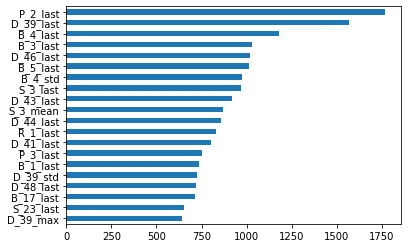

In [27]:
Series(models[0].get_feature_importance(), index=train.columns).sort_values(
    ascending=False)[:20][::-1].plot(kind='barh')

In [28]:
del train, X

### Inference

Inference code is also quite simple

In [29]:
def inference(flist, models):
    """
    Inference separated by partitions
    """
    pred_parts = []

    for path in flist:
        test = feature_extraction(path)
        X_test, index = test.values, test.index

        del test

        pred = np.zeros((X_test.shape[0], ), dtype=np.float32)

        for model in models:
            pred += model.predict(X_test, batch_size=5000000)[:, 0]

        pred /= len(models)
        pred_parts.append(Series(pred, index=index))

        del X_test
        print('{0} finished'.format(path))    
        
    return pd.concat(pred_parts, axis=0)

In [30]:
%%time
prediction = inference(
    [os.path.join(DATA_DIR, 'test_part{0}.feather'.format(x)) for x in range(4)],
    models
)

/opt/conda/lib/python3.7/site-packages/cudf/io/feather.py:16: UserWarning: Using CPU via PyArrow to read feather dataset, this may be GPU accelerated in the future
  "Using CPU via PyArrow to read feather dataset, this may "


../input/amexsavedasfeather/test_part0.feather finished
../input/amexsavedasfeather/test_part1.feather finished
../input/amexsavedasfeather/test_part2.feather finished
../input/amexsavedasfeather/test_part3.feather finished
CPU times: user 1min 40s, sys: 2min 38s, total: 4min 19s
Wall time: 5min 44s


The last thing to do is generating submission

In [31]:
ssub = pd.read_feather(os.path.join(DATA_DIR, 'ssub.feather')).set_index('my_id')
ssub['prediction'] = prediction

In [32]:
ssub[['customer_ID', 'prediction']]

,customer_ID,prediction
my_id,,
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.041570
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001296
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.047684
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.288642
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.854481
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.018517
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.774471
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.492161


In [33]:
ssub[['customer_ID', 'prediction']].to_csv('submission.csv', index=False)

#### Hope this kernel was helpful. Thanks for your attention! And Good luck :)